In [6]:
import torch
from torchvision.models import resnet18
from torchsummary import summary
from utils import classify
import numpy as np
from matplotlib import pyplot as plt
import os
from male import get_important_neurons, get_positions, associate_channels
import openai
from json import loads

In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
filename = 'overskirt.jpg'

In [9]:
model = resnet18(pretrained=True)
_ = model.eval()
# summary(model, (3, 224, 224))

In [10]:
%autoreload 2
probabilities, top_probabilities, categories, input_batch, input_tensor = classify(filename, model)

In [11]:
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))
if not os.path.exists(os.path.join('images', 'clipped', filename)):
    plt.imsave(os.path.join('images', 'clipped', filename), image_center_resized)

In [12]:
import pandas as pd
import os
descriptions = pd.read_csv(os.path.join('milan_results', 'resnet18_imagenet.csv'))
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['layer4']
layer_map = {'conv1' : model.bn1, 
             'layer1' : model.layer1[1].bn2, 
             'layer2' : model.layer2[1].bn2, 
             'layer3' : model.layer3[1].bn2, 
             'layer4' : model.layer4[1].bn2}

In [13]:
per_layer_results, per_layer_activations = get_important_neurons(10, 
                                                                 input_batch, 
                                                                 model, 
                                                                 layer_names, 
                                                                 layer_map, 
                                                                 descriptions, 
                                                                 probabilities)

/home/adamwsl/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


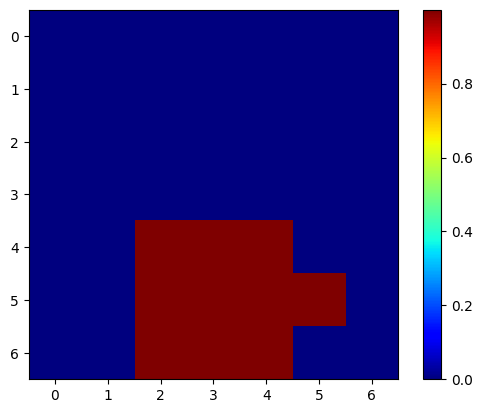

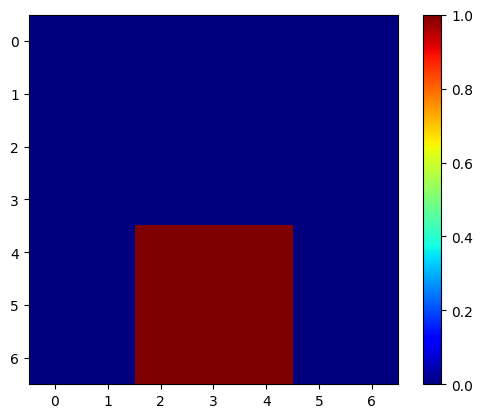

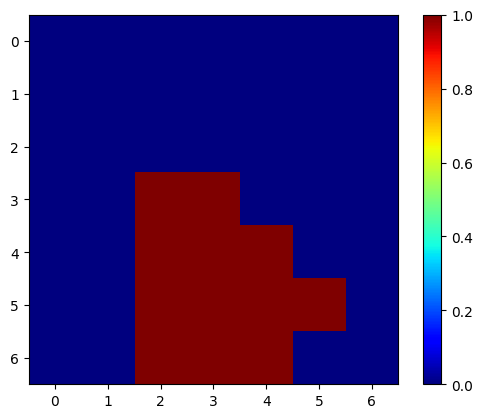

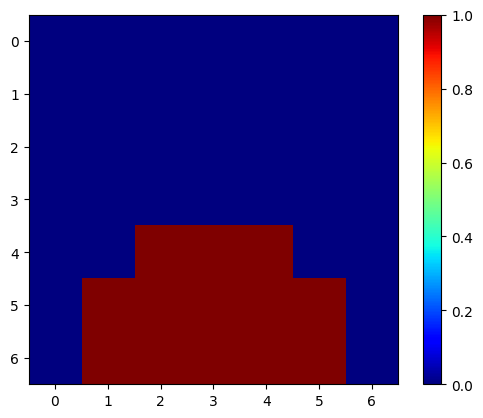

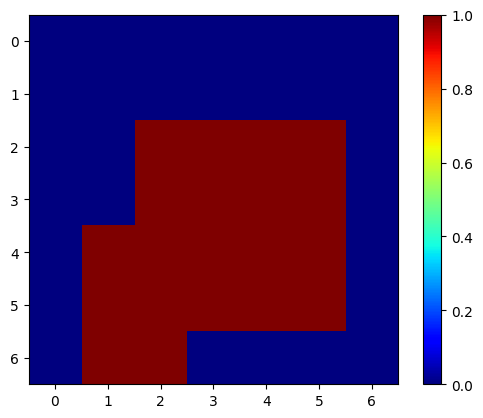

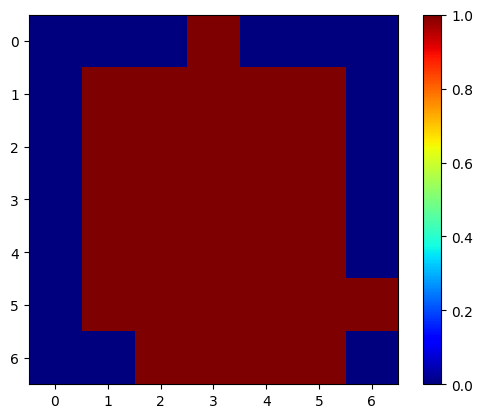

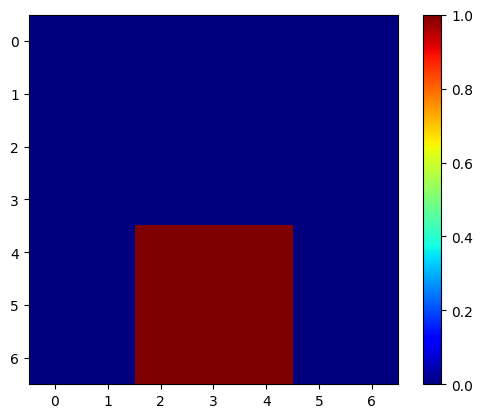

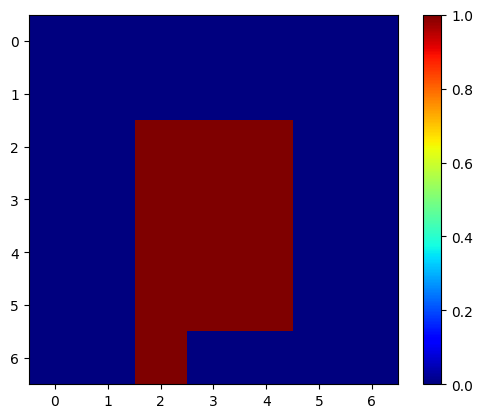

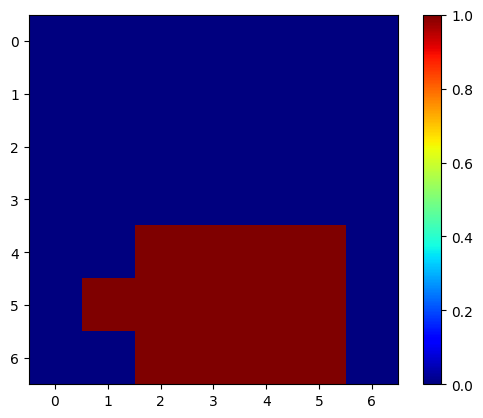

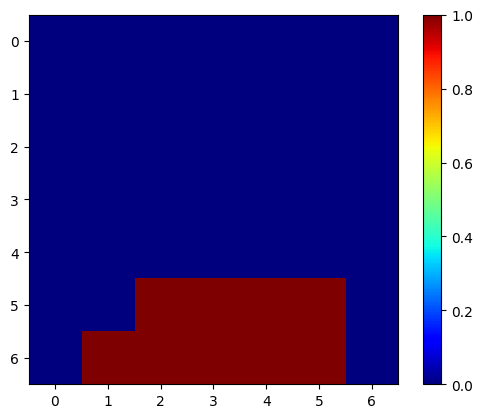

In [14]:
per_layer_positions = get_positions(per_layer_results, per_layer_activations, viz=True)

In [15]:
prompt = str(categories[0]) + ', '
tmp = []
positions = per_layer_positions['layer4']
results = per_layer_results['layer4']
for k, v in positions.items():
    tmp.append({'description' : results[k], 'positions' : [], 'id' : k})
    if len(v) <= 3:
        tmp[-1]['positions'] = v
prompt += str(tmp)
print(prompt)

hoopskirt, [{'description': 'Dresses', 'positions': ['right', 'bottom'], 'id': 5}, {'description': 'Shower caps', 'positions': ['right', 'bottom'], 'id': 458}, {'description': 'Items with designs', 'positions': ['right', 'bottom', 'center'], 'id': 196}, {'description': 'Items with straight features', 'positions': ['left', 'right', 'bottom'], 'id': 119}, {'description': 'Long, thin objects', 'positions': [], 'id': 442}, {'description': 'Animals and clothes', 'positions': [], 'id': 219}, {'description': 'Animals and clothes', 'positions': ['right', 'bottom'], 'id': 240}, {'description': 'Clothes', 'positions': ['right', 'bottom', 'center'], 'id': 241}, {'description': 'Animals and flowers', 'positions': ['left', 'right', 'bottom'], 'id': 86}, {'description': 'The indent in an hourglass shape', 'positions': ['left', 'right', 'bottom'], 'id': 40}]


In [16]:
with open('/home/adamwsl/.gpt_api_token/token.txt', 'r') as f:
    token = f.readline().strip()
with open('prompts/system_prompt.txt', 'r') as f:
    system_prompt = f.readline()
with open('prompts/example_prompt_1.txt', 'r') as f:
    example_prompt_1 = f.readline()
with open('prompts/example_output_1.txt', 'r') as f:
    example_output_1 = f.readline()
full_prompt = 'PROMPT: "' + prompt + '"'
print(full_prompt)

PROMPT: "hoopskirt, [{'description': 'Dresses', 'positions': ['right', 'bottom'], 'id': 5}, {'description': 'Shower caps', 'positions': ['right', 'bottom'], 'id': 458}, {'description': 'Items with designs', 'positions': ['right', 'bottom', 'center'], 'id': 196}, {'description': 'Items with straight features', 'positions': ['left', 'right', 'bottom'], 'id': 119}, {'description': 'Long, thin objects', 'positions': [], 'id': 442}, {'description': 'Animals and clothes', 'positions': [], 'id': 219}, {'description': 'Animals and clothes', 'positions': ['right', 'bottom'], 'id': 240}, {'description': 'Clothes', 'positions': ['right', 'bottom', 'center'], 'id': 241}, {'description': 'Animals and flowers', 'positions': ['left', 'right', 'bottom'], 'id': 86}, {'description': 'The indent in an hourglass shape', 'positions': ['left', 'right', 'bottom'], 'id': 40}]"


In [17]:
with open('prompts/full_prompt.txt', 'r') as f:
    whole_prompt = f.readlines()
whole_prompt = ''.join(whole_prompt)
full_prompt = whole_prompt + 'PROMPT: "' + prompt + '"'
print(full_prompt)

You are tasked with a problem of creating a deep convolutional network classification EXPLANATION. You will be given an python object in form of `chosen class, [{'neuron description' : *neuron description*, 'neuron positions' : *neuron positions*, neuron id' : *neuron id *}, {'neuron description' : *neuron description*, 'neuron positions' : *neuron positions*, 'neuron id' : *neuron id *}, …]` where `...` means that there might be numerous triplets more, and  which is a class that model has picked. I want you to do two things:
1. create a grammatically correct sentence which will explain the model's decision.
2. Decide which neuron descriptions do not fit with `chosen class` and do not include those neuron descriptions in the final explanation. What I mean by 'do not fit' is that they are completely unrelated with chosen class (like 'dentist' and 'animal heads'). Do include in final explanation neuron descriptions which aren't directly related to chosen class, but they may be indirectly

In [18]:
API_KEY = token
openai.api_key = API_KEY
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
        {"role": "user", "content": full_prompt},
    ], 
  temperature=0.1
)

In [19]:
from pprint import pprint
pprint(response["choices"][0]["message"]["content"])

("The model's decision was 'hoopskirt' because in the last layer it discovered "
 "'Dresses' at the 'right' and 'bottom' of the image (neuron 5), 'Shower caps' "
 "at the 'right' and 'bottom' of the image (neuron 458), 'Items with designs' "
 "at the 'right', 'bottom', and 'center' of the image (neuron 196), 'Items "
 "with straight features' at the 'left', 'right', and 'bottom' of the image "
 "(neuron 119), 'Animals and clothes' (neuron 219), 'Animals and clothes' at "
 "the 'right' and 'bottom' of the image (neuron 240), 'Clothes' at the "
 "'right', 'bottom', and 'center' of the image (neuron 241), 'Animals and "
 "flowers' at the 'left', 'right', and 'bottom' of the image (neuron 86), and "
 "'The indent in an hourglass shape' at the 'left', 'right', and 'bottom' of "
 'the image (neuron 40).')


In [20]:
%autoreload 2
from male import associate_channels
x = associate_channels(input_batch=input_batch, 
                       prev_layer=model.layer3[1].conv2, 
                       prev_out_channels=256,
                       curr_layer=model.layer4[0].conv1, 
                       target_ch_id=266, 
                       model=model)
print(tops := list(torch.argsort(x).numpy())[:10])

[119, 163, 220, 120, 252, 231, 188, 128, 77, 193]


In [21]:
query = descriptions[descriptions['layer'] == 'layer2']
tops = list(torch.argsort(x).numpy())[:10]
print(tops)
query =  query[query['unit'].isin(tops)]
query

[119, 163, 220, 120, 252, 231, 188, 128, 77, 193]


,layer,unit,description
205,layer2,77,Stripes
247,layer2,119,The center of flowers
248,layer2,120,Text


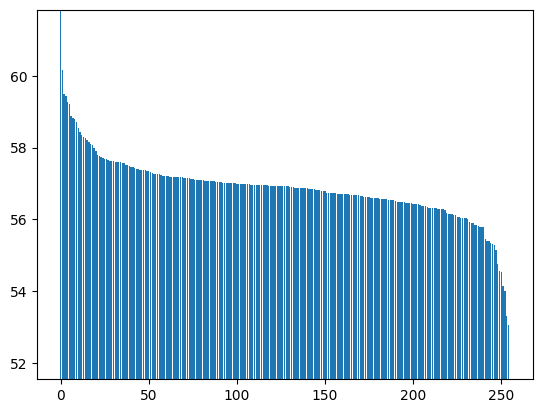

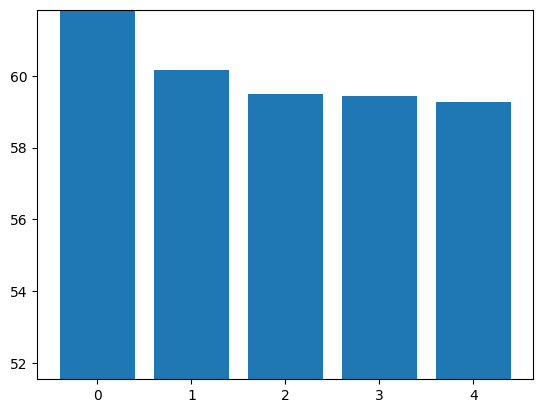

In [22]:
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)
plt.show()
plt.ylim(min(y), max(y))
plt.bar(range(len(y[:5])), y[:5])
plt.show()